In [1]:
# importing libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import os
import math
from scipy.linalg import svd

In [2]:
# importing elpileptic and healthy data
def load_csv_files(directory):
    all_df = []    
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            all_df.append(df)
    
    combined_df = pd.concat(all_df, ignore_index=True)   
    return combined_df

epi_directory = '/kaggle/input/epileptic'
healthy_directory = '/kaggle/input/healthy'

# loading epileptical data 
epi_data = load_csv_files(epi_directory)
# loading healthy data
heal_data = load_csv_files(healthy_directory)

In [3]:
# converting the dataframe into 2-D numpy-array
epi_data = np.asarray(epi_data.T)
heal_data = np.asarray(heal_data.T)
# adjusting sizes
epi_resample_data = np.zeros_like(heal_data)
for i in np.arange(0, 19):
    epi_resample_data[i] = epi_data[i][ : 1207161]

In [4]:
epi_resample_data.shape, heal_data.shape

((19, 1207161), (19, 1207161))

### third feautre : entropy SVD

In [5]:
def eeg_svd(eeg_data):
    # Compute the singular value decomposition and capturing the singular values
    singular_values = svd(eeg_data, compute_uv = False)
    return singular_values

In [6]:
# calculating the feautre of epi and healthy data
epi_feautre = eeg_svd(epi_resample_data)
heal_feautre = eeg_svd(heal_data)

In [7]:
he_obs = epi_feautre
epi_obs = heal_feautre

mean_he_obs = np.mean(he_obs)
mean_epi_obs = np.std(epi_obs)

s_d_he_obs = np.mean(he_obs)
s_d_epi_obs = np.std(epi_obs)

In [8]:
# taking the log of the pdfs of epi and heal
p_h0_log =  np.log(1/np.sqrt(2*np.pi*s_d_he_obs)) + (-0.5*((he_obs - mean_he_obs)/s_d_he_obs)**2)
p_h1_log =  np.log(1/np.sqrt(2*np.pi*s_d_epi_obs)) + (-0.5*((epi_obs - mean_epi_obs - 20e-7)/s_d_epi_obs)**2)

# taking log LRT
ln_lrt = p_h1_log - p_h0_log

Text(0.5, 1.0, 'Probability Distribution Function of healthy vs epileptical')

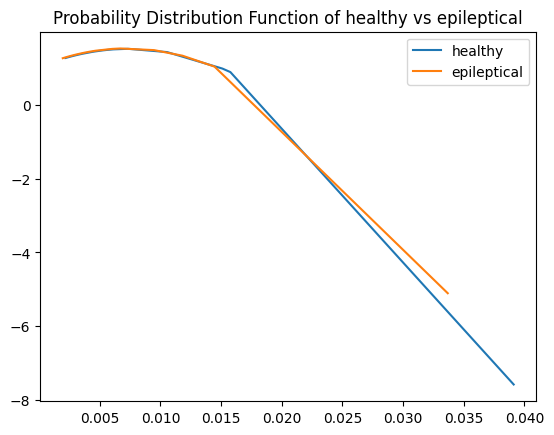

In [9]:
plt.plot(he_obs, p_h0_log, label = 'healthy')
plt.plot(epi_obs, p_h1_log, label = 'epileptical')
plt.legend()
plt.title('Probability Distribution Function of healthy vs epileptical')

In [10]:
# finding the threshold
thresh = np.median(ln_lrt)

# finding lrt of heal (h0) and epi(h1)
lrt_h1 = []
lrt_h0 = []
for i in ln_lrt:
    if i > thresh:
        lrt_h1.append(i)
    else : 
        lrt_h0.append(i)

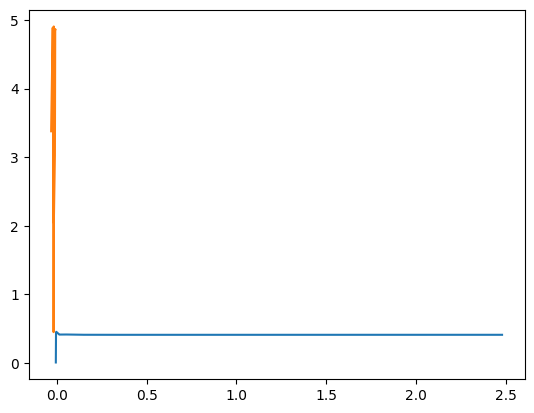

In [11]:
obs=(lrt_h1)
mean=np.mean(lrt_h1)
sigma=np.std(lrt_h1)

p_lrt_h1=(1/np.sqrt(2*np.pi*sigma))*np.exp(-0.5*((obs-mean)/sigma)**2)

obs=(lrt_h0)
mean=np.mean(lrt_h0)
sigma=np.std(lrt_h0)

p_lrt_h0=(1/np.sqrt(2*np.pi*sigma))*np.exp(-0.5*((obs-mean)/sigma)**2)

plt.plot(np.sort(lrt_h1), p_lrt_h1)
plt.plot(np.sort(lrt_h0), p_lrt_h0)

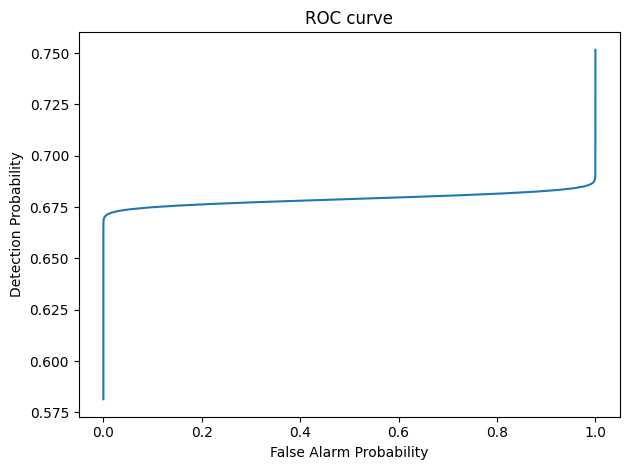

In [12]:
# plotting ROC curve
obs = (lrt_h1)
mean_pd = np.mean(lrt_h1)
sigma_pd = np.std(lrt_h1)

obs = (lrt_h0)
mean_pfa = np.mean(lrt_h0)
sigma_pfa = np.std(lrt_h0)

threshold=np.arange(-20* abs(max(lrt_h0)),20*np.abs(max(lrt_h0)), 2*np.abs(max(lrt_h0))/len(lrt_h0))
 
p_fa=[]
p_d=[]

for i in threshold:
    prob_false_alarm = 1 - norm.cdf(i, mean_pfa, sigma_pfa)
    p_fa.append(prob_false_alarm)
        
    prob_det = 1 - norm.cdf(i, mean_pd, sigma_pd)
    p_d.append(prob_det)

plt.plot(p_fa, p_d)
plt.xlabel("False Alarm Probability")
plt.ylabel("Detection Probability")
plt.title("ROC curve")
plt.tight_layout()
plt.show()

In [17]:
np.unique(threshold).shape

(200,)

In [13]:
def auc_from_pfa_pd(pfa, pd):
    # Sort (PFA, PD) pairs by increasing PFA
    sorted_indices = np.argsort(pfa)
    sorted_pfa = np.array(pfa)[sorted_indices]
    sorted_pd = np.array(pd)[sorted_indices]
    # Interpolate the ROC curve
    roc_curve = np.trapz(sorted_pd, sorted_pfa)
    return roc_curve

# Calculate AUC
auc = auc_from_pfa_pd(p_fa, p_d)
print("AUC:", auc)

AUC: 0.6789269479579378
